In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt



In [3]:

data = scipy.io.loadmat('ftt-data.mat')['data']  
print("数据形状:", data.shape)  


fs = 500  
n_channels, n_timepoints, n_trials = data.shape
time_axis = np.arange(n_timepoints) / fs  


freq_bands = {
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}
band_colors = {
    'Theta': 'blue',
    'Alpha': 'green',
    'Beta': 'red',
    'Gamma': 'orange'
}
# 4. Select specific channels (Python uses 0-based indexing)
selected_channels = {
    25: 'C3 ',
    28: 'FC5'
}
# 5. 准备存储结构
band_signals = {band: np.zeros((len(selected_channels), n_timepoints)) 
                for band in freq_bands}
original_signals = np.zeros((len(selected_channels), n_timepoints))


数据形状: (32, 1000, 49)


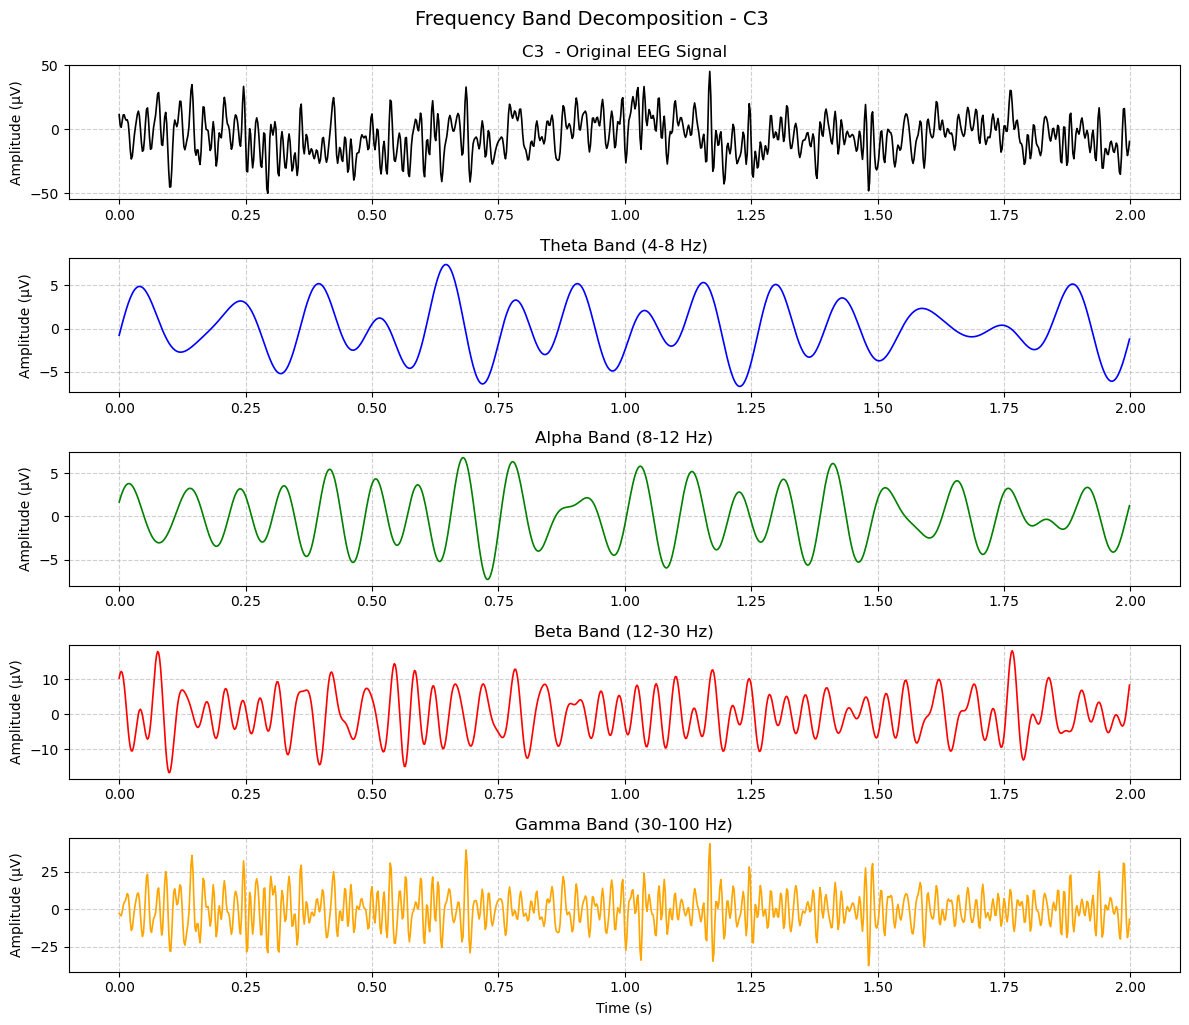

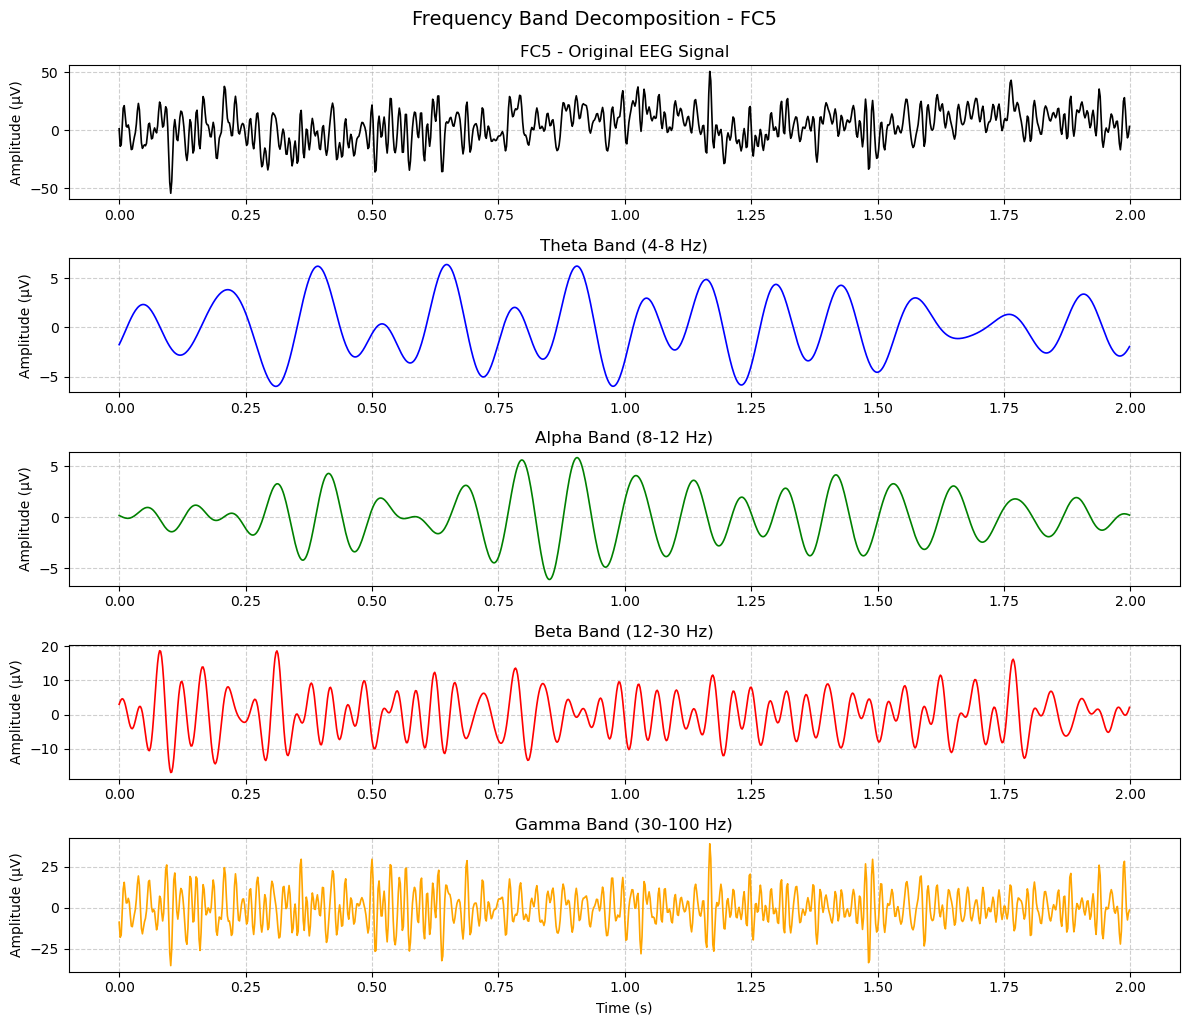

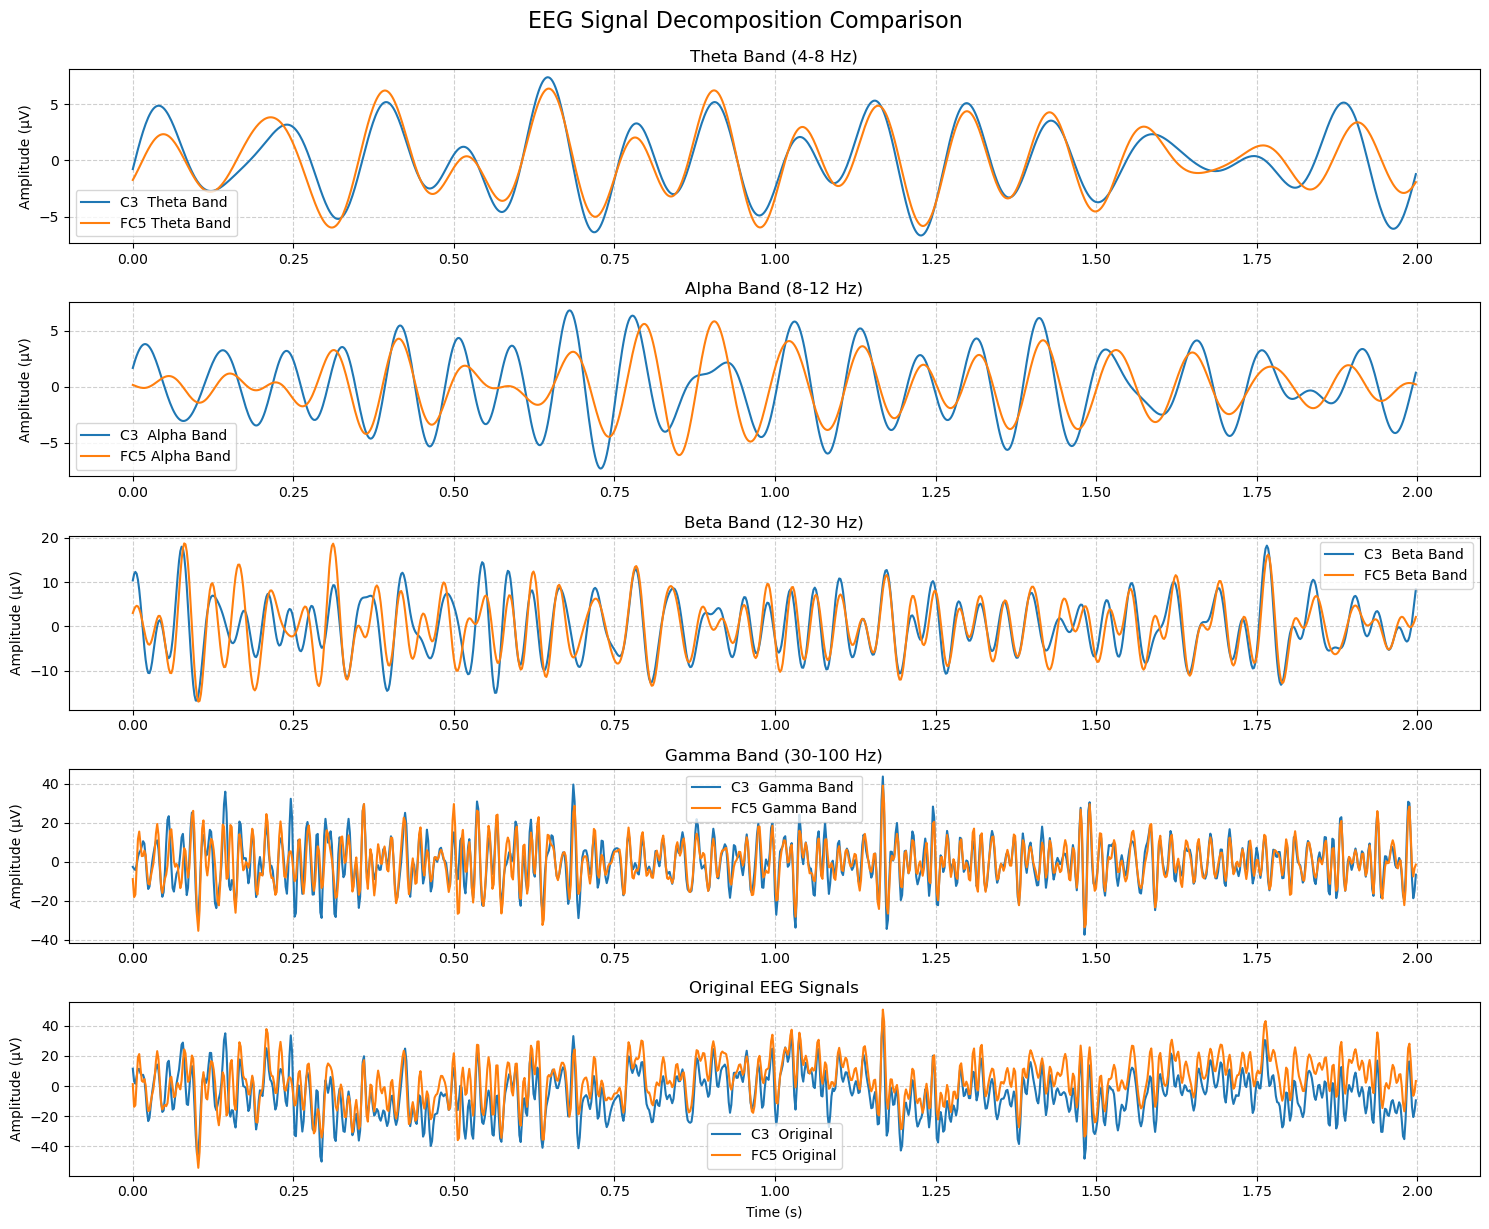

In [5]:
# 5. Process data for first trial
trial_idx = 0  # Using first trial
results = {}

for channel_idx, channel_name in selected_channels.items():
    # Get original signal
    signal = data[channel_idx, :, trial_idx]
    
    # Perform FFT
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n_timepoints, 1/fs)
    
    # Store results
    channel_results = {
        'Original': signal,
        'bands': {}
    }
    
    # Process each frequency band
    for band, (low, high) in freq_bands.items():
        # Create bandpass mask
        mask = np.logical_or(
            np.logical_and(freqs >= low, freqs <= high),
            np.logical_and(freqs <= -low, freqs >= -high)
        )
        
        # Filter frequency components
        filtered_fft = fft_result * mask
        
        # Reconstruct time domain signal
        reconstructed = np.real(np.fft.ifft(filtered_fft))
        channel_results['bands'][band] = reconstructed
    
    results[channel_name] = channel_results

# 6. Plot results - separate subplots for each band
for channel_name, channel_data in results.items():
    plt.figure(figsize=(12, 10))
    
    # Plot original signal
    plt.subplot(5, 1, 1)
    plt.plot(time_axis, channel_data['Original'], 'k', linewidth=1.2)
    plt.title(f'{channel_name} - Original EEG Signal')
    plt.ylabel('Amplitude (μV)')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Plot each frequency band in separate subplots
    for i, (band, color) in enumerate(band_colors.items()):
        plt.subplot(5, 1, i+2)
        plt.plot(time_axis, channel_data['bands'][band], color, linewidth=1.2)
        plt.title(f'{band} Band ({freq_bands[band][0]}-{freq_bands[band][1]} Hz)')
        plt.ylabel('Amplitude (μV)')
        plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.suptitle(f'Frequency Band Decomposition - {channel_name}', fontsize=14, y=1.02)
    plt.savefig(f"{channel_name}_Decomposition.png", 
               dpi=300, 
               bbox_inches='tight',
               pad_inches=0.1)
    plt.show()

# 7. Optional: Combined plot for both channels
plt.figure(figsize=(15, 12))
n_bands = len(freq_bands)

for b, (band, color) in enumerate(band_colors.items()):
    plt.subplot(n_bands+1, 1, b+1)
    
    for channel_name in selected_channels.values():
        plt.plot(time_axis, results[channel_name]['bands'][band], 
                label=f'{channel_name} {band} Band')
    
    plt.title(f'{band} Band ({freq_bands[band][0]}-{freq_bands[band][1]} Hz)')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

# Add original signals at the bottom
plt.subplot(n_bands+1, 1, n_bands+1)
for channel_name in selected_channels.values():
    plt.plot(time_axis, results[channel_name]['Original'], 
            label=f'{channel_name} Original')
plt.title('Original EEG Signals')
plt.ylabel('Amplitude (μV)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.suptitle('EEG Signal Decomposition Comparison', fontsize=16, y=1.02)
plt.show()